## Import all the libraries

In [1]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [2]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=9;dmax=30
# depth of the desired comparison profile in m
depthmin=1000
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000


In [3]:
# Parameters
ymin = 2010
mmin = 1
dmin = 1
ymax = 2010
mmax = 9
dmax = 30
depthmin = 2000
radius_max = 0.25
period = 5
number_of_model_profiles = 100000


In [4]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [5]:
sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


In [6]:
vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
                   110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,
                   420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,
                   820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,
                   1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]
all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))


In [7]:
for prof in np.arange(nb_profilesEN4):
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    dsprof=xr.open_dataset(outname)

    depth_en4=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']
    obs_lat=dsprof['latitude_profileEN4']
    obs_lon=dsprof['longitude_profileEN4']
    obs_time=dsprof['time_profileEN4']
    
    # Project the profile to standart vertical levels
    temp_en4_standart=np.interp(vert_standart,depth_en4,temp_en4)
    salt_en4_standart=np.interp(vert_standart,depth_en4,salt_en4)
    mean_temp_model_standart=np.interp(vert_standart,depth_en4,mean_temp_model)
    mean_salt_model_standart=np.interp(vert_standart,depth_en4,mean_salt_model)
    percent10_temp_model_standart=np.interp(vert_standart,depth_en4,percent10_temp_model)
    percent10_salt_model_standart=np.interp(vert_standart,depth_en4,percent10_salt_model)
    percent90_temp_model_standart=np.interp(vert_standart,depth_en4,percent90_temp_model)
    percent90_salt_model_standart=np.interp(vert_standart,depth_en4,percent90_salt_model)

    #Fill the all profiles
    all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
    all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
    all_temp_en4[prof,:]=temp_en4_standart[:]
    all_salt_en4[prof,:]=salt_en4_standart[:]
    all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
    all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
    all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
    all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]


Processing profile  Profile_20100902_prof.nc_85


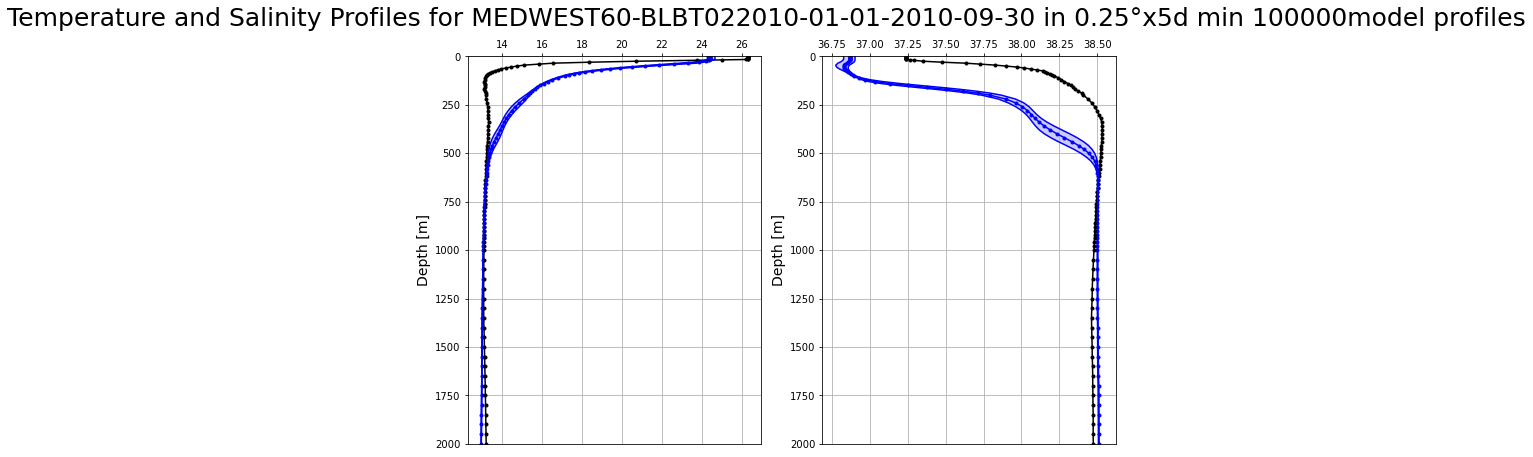

In [8]:
        fig, axs = plt.subplots(1,2, figsize=(10, 6))
        axs = axs.ravel()
        title = 'Temperature and Salinity Profiles for MEDWEST60-BLBT02'+str(datemin)+'-'+str(datemax)+' in '+str(radius_max)+'°x'+str(period)+'d min '+str(number_of_model_profiles)+'model profiles'
        plt.suptitle(title,size = 25,y=1.05)
        axs[0].plot(mean_temp_model_standart,vert_standart,'b.-', label='temp model')
        axs[0].plot(temp_en4_standart,vert_standart,'k.-', label='temp en4')
        axs[0].set_ylabel('Depth [m]', size=14)
        axs[0].set_ylim(depthmin, 0)
        axs[0].grid(True, which='both')
        axs[0].xaxis.tick_top()
        axs[0].xaxis.set_label_position('top') 
        axs[0].plot(percent10_temp_model_standart,vert_standart,'b-', label='percent10')
        axs[0].plot(percent90_temp_model_standart,vert_standart,'b-', label='percent90')
        axs[0].fill_betweenx(vert_standart, percent10_temp_model_standart, x2=percent90_temp_model_standart, alpha=0.2, facecolor='b')

        axs[1].plot(mean_salt_model_standart,vert_standart,'b.-', label='salt model')
        axs[1].plot(salt_en4_standart,vert_standart,'k.-', label='salt en4')
        axs[1].set_ylabel('Depth [m]', size=14)
        axs[1].set_ylim(depthmin, 0)
        axs[1].grid(True, which='both')
        axs[1].xaxis.tick_top()
        axs[1].xaxis.set_label_position('top') 
        axs[1].plot(percent10_salt_model_standart,vert_standart,'b-', label='percent10')
        axs[1].plot(percent90_salt_model_standart,vert_standart,'b-', label='percent90')
        axs[1].fill_betweenx(vert_standart, percent10_salt_model_standart, x2=percent90_salt_model_standart, alpha=0.2, facecolor='b')
        fig.tight_layout()
        plt.savefig('plots/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.png')
